# Uncover distributional imbalances 

**Main Objective:**  
This notebook aims to uncover distributional imbalances by combining **demographic data** (age, gender, location) from the **Candidates** sheet of the reverse matching dataset and **skill data** extracted by the parser from raw CVs.

## Steps:

- **Analyze distributional skews**  
    - **Gender** distribution 
    - **Location** distribution  
    - **Hard vs. soft skills** distribution  

- **Visualize imbalances**  
  - Use bar charts to highlight **over** or **under** representation.

- **First analysis of parser induced bias**  
  - Identify patterns where the parser **may** systematically favor or overlook certain groups or skill types.  


**Why This Matters** 

> Detecting these imbalances is **critical** to designing a robust, fair pipeline that flags and mitigates biases introduced by the CV parser relying only on raw CV inputs and their parsed outputs.  

## Merge & prepare data 
  - Bring together candidate demographic data and their extracted skills.  

In [30]:
%load_ext autoreload 
%autoreload 2
import polars as pl

from hiring_cv_bias.config import (
    CLEANED_REVERSE_MATCHING_PATH,
    CLEANED_SKILLS,
    HARD_SOFT_SKILLS,
)
from hiring_cv_bias.exploration.gender_analysis import (
    add_zippia_columns,
    compute_bias_strenght,
    get_category_distribution,
    get_skill_target_share,
    plot_bias_skills_bar,
)
from hiring_cv_bias.exploration.utils import (
    plot_distribution_bar,
    split_df_per_attribute,
)
from hiring_cv_bias.exploration.visualize import (
    compute_and_plot_disparity,
    plot_histogram,
    plot_target_distribution,
)
from hiring_cv_bias.utils import load_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
df_skills = load_data(CLEANED_SKILLS)
df_info_candidates = load_data(CLEANED_REVERSE_MATCHING_PATH)
df_skills.head()

CANDIDATE_ID,Skill,Skill_Type
i64,str,str
7990324,"""Computer Literacy""","""IT_Skill"""
7990324,"""Dental Assistant (m/f)""","""Job_title"""
7990324,"""General Labourer (other) (m/f)""","""Job_title"""
7990324,"""Intern (m/f)""","""Job_title"""
7990324,"""Italian""","""Language_Skill"""


In [32]:
df_info_candidates.sample(5)

CANDIDATE_ID,Gender,Age_bucket,professional_categories_int,matterknowledges,languages,regulatedtrainings,candidatecity,drivinglicenses,LONGITUDE,LATITUDE,experience,Location
i64,str,str,str,str,str,str,str,str,f64,f64,str,str
5837759,"""Male""","""25-34""","""magazziniere/magazziniera""",null,null,null,"""MIRANO""",null,12.109877,45.49277,"""guardia del corpo/chauffeur pr…","""NORTH"""
5920423,"""Male""","""25-34""","""analista programmatore""",null,null,null,"""NAPOLI""",null,14.248768,40.835885,"""analista/programmatore;stagist…","""SOUTH"""
5776720,"""Male""","""25-34""","""Impiegato Commerciale""",null,null,null,"""VILLASANTA""",null,9.301397,45.603924,"""account director;impiegato tec…","""NORTH"""
148015,"""Male""","""25-34""","""Geometra e tecnico di costruzi…","""Microsoft Office;Google Chrome…",null,null,"""PIEVE A NIEVOLE""","""B;A""",10.796112,43.879112,"""responsabile di produzione e d…","""CENTER"""
7036334,"""Female""","""55-74""","""account manager""",null,null,null,"""RAVENNA""",null,12.201762,44.416141,"""addetto alle attività ricreati…","""CENTER"""


## Gender Analysis

In this section, we analyze the distribution of extracted skills across candidates by incorporating **gender** information.

We focus on:

* Exploring the distribution of skills by gender.
* Identifying job roles where the skill sets parsed from CVs exhibit significant gender based disparities.
* Uncovering potential biases in how skills are emphasized for different genders.

In [33]:
df_skills_with_gender = df_skills.join(
    df_info_candidates.select(["CANDIDATE_ID", "Gender"]), on="CANDIDATE_ID"
)
df_skills_with_gender.head()

CANDIDATE_ID,Skill,Skill_Type,Gender
i64,str,str,str
7990324,"""Computer Literacy""","""IT_Skill""","""Female"""
7990324,"""Dental Assistant (m/f)""","""Job_title""","""Female"""
7990324,"""General Labourer (other) (m/f)""","""Job_title""","""Female"""
7990324,"""Intern (m/f)""","""Job_title""","""Female"""
7990324,"""Italian""","""Language_Skill""","""Female"""


In [34]:
gender_counts_df = get_category_distribution(df_info_candidates, "Gender")
gender_counts_df

Gender,count,percentage
str,u32,f64
"""Male""",3984,53.0
"""Female""",3420,45.5
"""Other""",106,1.4
"""Unknown""",11,0.1


We begin by examining the overall gender composition of the candidate pool, which shows 53.0% male and 45.5% female, therefore rather balanced and a small fraction identifying as “Other” or “Unknown."

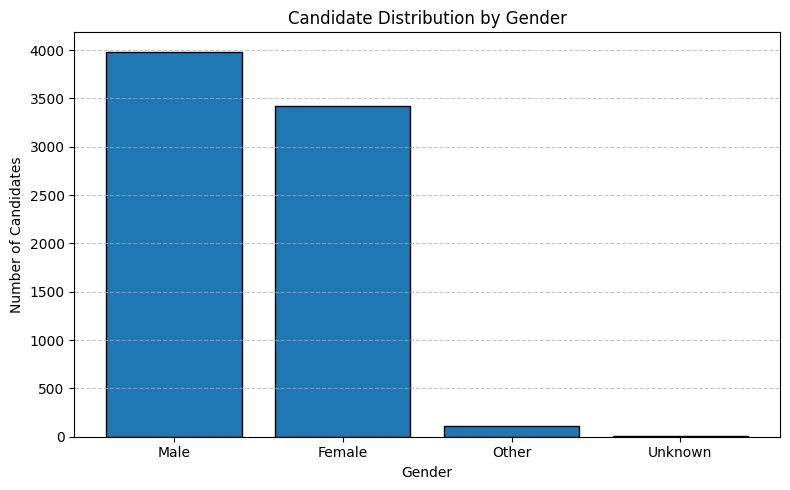

In [35]:
plot_distribution_bar(
    gender_counts_df,
    x_col="Gender",
    y_col="count",
    x_label="Gender",
    y_label="Number of Candidates",
    title="Candidate Distribution by Gender",
)

Compute for each skill type the counts and percentages of male vs. female candidates and their differences.

**Steps:**  
1. Count males and females per skill type. These counts are **normalized** with respect to the prior distribution. 
2. Calculate total count, percent female/male (rounded to 1 decimal), absolute and percentage differences.  
3. Sort by descending total count.

In [36]:
df_category_with_gender = get_skill_target_share(
    df_skills_with_gender,
    gender_counts_df,
    target_col="Gender",
    target_values=["Male", "Female"],
)
df_category_with_gender

Skill_Type,count_male,count_female,count_total,perc_male,perc_female,count_diff,perc_diff
str,i64,i64,i64,f64,f64,i64,f64
"""Professional_Skill""",32292,34238,66530,48.5,51.5,-1946,-3.0
"""Job_title""",11171,11643,22814,49.0,51.0,-472,-2.0
"""IT_Skill""",11282,10628,21910,51.5,48.5,654,3.0
"""Language_Skill""",6199,6584,12783,48.5,51.5,-385,-3.0
"""DRIVERSLIC""",1288,1012,2300,56.0,44.0,276,12.0


We identify **skill categories** with the gender imbalance, highlighting those that are disproportionately associated with either male or female candidates. 

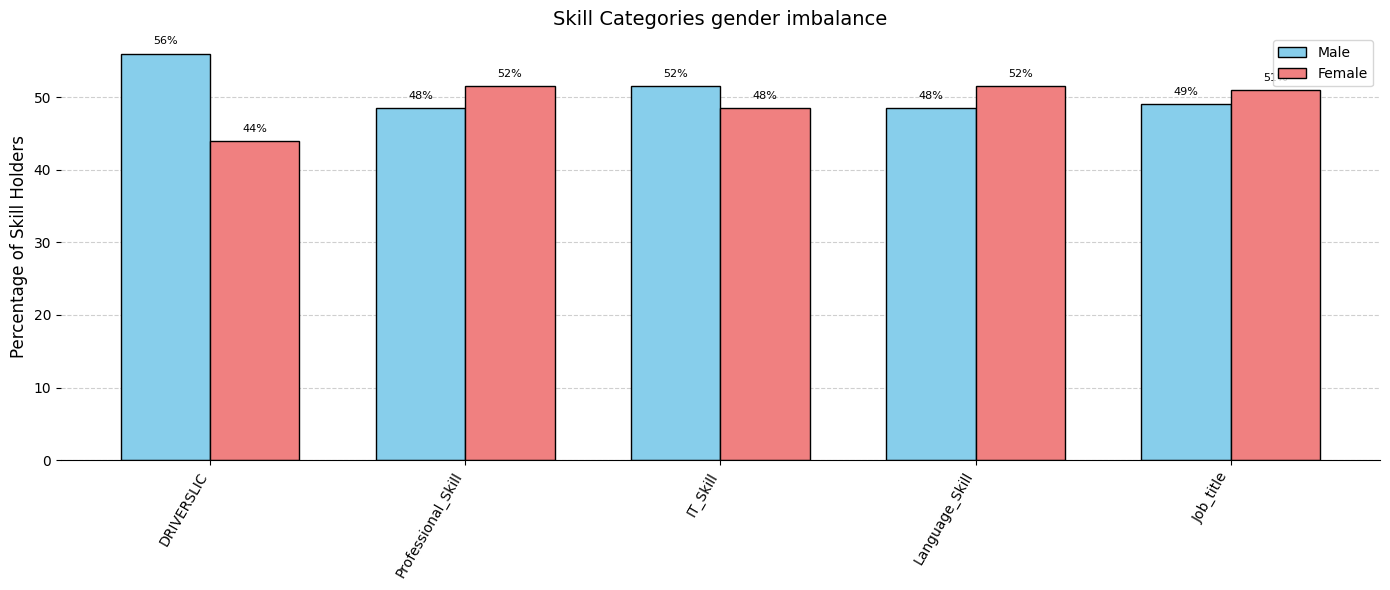

In [37]:
gender_percs_dict = {"Male": "perc_male", "Female": "perc_female"}
gender_colors = {"Male": "skyblue", "Female": "lightcoral"}

plot_bias_skills_bar(
    df_category_with_gender,
    "Skill_Type",
    gender_percs_dict,
    "perc_diff",
    "Skill Categories gender imbalance",
    colors=gender_colors,
)

Now we analyze gender representation across parsed skills by computing both **absolute counts** (normalized by prior distribution) and **relative percentages** for male and female candidates. The objective is to identify skills that show a significant **gender imbalance**.

We group the data by each unique combination of `Skill` and `Skill_Type` and compute the following:

- `count_male`: number of male candidates who have the skill 
- `count_female`: number of female candidates who have the skill  
- `count_total = count_male + count_female`  
- `perc_male = (count_male / count_total) × 100`  
- `perc_female = (count_female / count_total) × 100`  
- `perc_diff = perc_male - perc_female`  
- `count_diff = count_male - count_female`  

To quantify the **strength of gender bias** for each skill, we define the following metric:



$$
\text{bias\_strength} = \left| \frac{\text{count\_diff}}{\text{count\_total}} \cdot \log(1 + \text{count\_total}) \right|
$$


This formula combines:
- the **normalized difference** between male and female counts,
- a **logarithmic weighting** that increases confidence in imbalances occurring in larger samples.

The result is a score that emphasizes statistically meaningful disparities.

A higher `bias_strength` indicates a stronger imbalance between male and female representations for that particular skill.

In [38]:
df_gender_bias = compute_bias_strenght(df_skills_with_gender, gender_counts_df)
df_gender_bias

Skill,Skill_Type,count_male,count_female,count_total,perc_male,perc_female,count_diff,perc_diff,bias_strength
str,str,i64,i64,i64,f64,f64,i64,f64,f64
"""Italian""","""Language_Skill""",3086,3085,6171,50.0,50.0,1,0.0,0.001414
"""English""","""Language_Skill""",1555,1565,3120,49.8,50.2,-10,-0.4,0.025788
"""Microsoft Office""","""IT_Skill""",1301,1529,2830,46.0,54.0,-228,-8.0,0.640365
"""Driver License B""","""DRIVERSLIC""",869,872,1741,49.9,50.1,-3,-0.2,0.012859
"""Microsoft Word""","""IT_Skill""",777,879,1656,46.9,53.1,-102,-6.2,0.456583
…,…,…,…,…,…,…,…,…,…
"""Personal Injury Law""","""Professional_Skill""",0,1,1,0.0,100.0,-1,-100.0,0.693147
"""Consultation Service""","""Professional_Skill""",0,1,1,0.0,100.0,-1,-100.0,0.693147
"""Immunohaematology""","""Professional_Skill""",0,1,1,0.0,100.0,-1,-100.0,0.693147


In [39]:
df_gender_bias.sort(pl.col("bias_strength"), descending=True).head(20)

Skill,Skill_Type,count_male,count_female,count_total,perc_male,perc_female,count_diff,perc_diff,bias_strength
str,str,i64,i64,i64,f64,f64,i64,f64,f64
"""Baby-Sitter (m/f)""","""Job_title""",3,161,164,1.8,98.2,-158,-96.4,4.919143
"""Programmable Logic Controllers""","""Professional_Skill""",243,21,264,92.0,8.0,222,84.0,4.692046
"""Forklift Trucks""","""Professional_Skill""",645,112,757,85.2,14.8,533,70.4,4.668632
"""Construction Worker (m/f)""","""Job_title""",105,0,105,100.0,0.0,105,100.0,4.663439
"""Secretary (m/f)""","""Job_title""",10,174,184,5.4,94.6,-164,-89.2,4.652926
…,…,…,…,…,…,…,…,…,…
"""Hydraulics""","""Professional_Skill""",126,14,140,90.0,10.0,112,80.0,3.959008
"""Telephone Skills""","""Professional_Skill""",3,69,72,4.2,95.8,-66,-91.6,3.932921
"""Room Attendant (m/f)""","""Job_title""",0,47,47,0.0,100.0,-47,-100.0,3.871201


> Note: From these results, we can see that certain skills known to be heavily "gender skewed" in society have been identified. <br>
Although a high perc_diff highlights strong imbalances, it alone would also find **rare** skills with extreme ratios (for example, 1 occurrence versus 0). By adding a logarithmic term based on counts, we ensure that only skills with both a large percentage difference and a sufficiently high frequency rise to the top. <br>
This `bias_strenght` metric therefore uncovers the most widespread, gender-biased skills in our dataset.

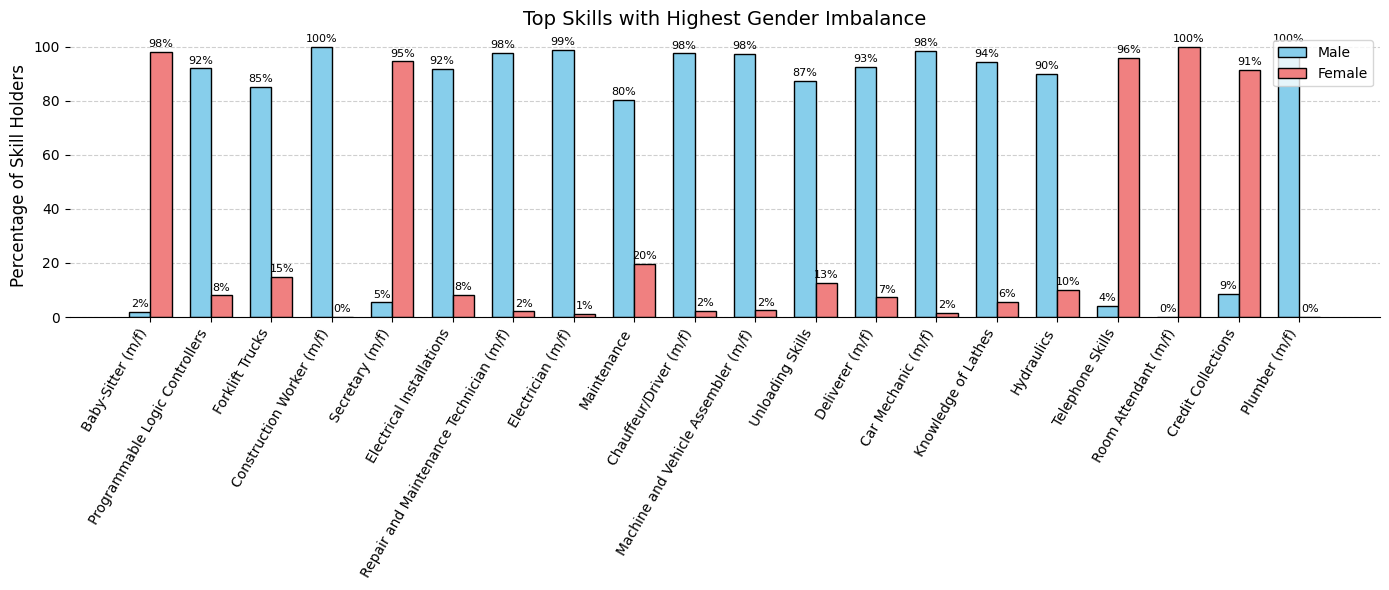

In [40]:
plot_bias_skills_bar(
    df_gender_bias,
    "Skill",
    gender_percs_dict,
    "bias_strength",
    "Top Skills with Highest Gender Imbalance",
    top_n=20,
    colors=gender_colors,
)

In this section, we're going to examine gender bias in the candidates job experiences (**Job Titles**) to understand how they differ for male and female candidates.

For doing this we append two new columns `perc_female_zippia` and `perc_male_zippia` by scraping **Zippia** (USA) for the percentage of men and women in each role.

By this we’ll see whether the same male/female proportions that we observe in our parsed skills and roles align with the real world distribution of those occupations determining whether observed disparities could reflect **parser errors** or **real world biases** already present in our CVs.




Example: If our parsed CVs dataset shows that 10% of “Software Engineer” CVs are female but Zippia reports 30%, this gap **may** indicate a parser bias. Conversely, if both sources match closely, it could suggests that any skew is likely a reflection of broader societal patterns rather than a flaw in the parser extraction process.

In [41]:
df = df_gender_bias.sort(pl.col("bias_strength"), descending=True).head(30)
job_df = df.filter(pl.col("Skill_Type") == "Job_title")
job_df

Skill,Skill_Type,count_male,count_female,count_total,perc_male,perc_female,count_diff,perc_diff,bias_strength
str,str,i64,i64,i64,f64,f64,i64,f64,f64
"""Baby-Sitter (m/f)""","""Job_title""",3,161,164,1.8,98.2,-158,-96.4,4.919143
"""Construction Worker (m/f)""","""Job_title""",105,0,105,100.0,0.0,105,100.0,4.663439
"""Secretary (m/f)""","""Job_title""",10,174,184,5.4,94.6,-164,-89.2,4.652926
"""Repair and Maintenance Technic…","""Job_title""",94,2,96,97.9,2.1,92,95.8,4.384098
"""Electrician (m/f)""","""Job_title""",80,1,81,98.8,1.2,79,97.6,4.297911
…,…,…,…,…,…,…,…,…,…
"""Plumber (m/f)""","""Job_title""",45,0,45,100.0,0.0,45,100.0,3.828641
"""Bricklayer (m/f)""","""Job_title""",43,0,43,100.0,0.0,43,100.0,3.78419
"""Warehouse Employee (m/f)""","""Job_title""",472,122,594,79.5,20.5,350,59.0,3.764304


In [42]:
job_df = add_zippia_columns(job_df)
job_df

Skill,Skill_Type,count_male,count_female,count_total,perc_male,perc_female,count_diff,perc_diff,bias_strength,perc_female_zippia,perc_male_zippia
str,str,i64,i64,i64,f64,f64,i64,f64,f64,f64,f64
"""Baby-Sitter (m/f)""","""Job_title""",3,161,164,1.8,98.2,-158,-96.4,4.919143,86.0,14.0
"""Construction Worker (m/f)""","""Job_title""",105,0,105,100.0,0.0,105,100.0,4.663439,6.0,94.0
"""Secretary (m/f)""","""Job_title""",10,174,184,5.4,94.6,-164,-89.2,4.652926,90.0,10.0
"""Repair and Maintenance Technic…","""Job_title""",94,2,96,97.9,2.1,92,95.8,4.384098,4.0,96.0
"""Electrician (m/f)""","""Job_title""",80,1,81,98.8,1.2,79,97.6,4.297911,4.0,96.0
…,…,…,…,…,…,…,…,…,…,…,…
"""Plumber (m/f)""","""Job_title""",45,0,45,100.0,0.0,45,100.0,3.828641,4.0,96.0
"""Bricklayer (m/f)""","""Job_title""",43,0,43,100.0,0.0,43,100.0,3.78419,3.0,97.0
"""Warehouse Employee (m/f)""","""Job_title""",472,122,594,79.5,20.5,350,59.0,3.764304,17.0,83.0


## Geographical Analysis

In this section, we analyze the distribution of extracted skills across candidates by incorporating **geographical position** information.

We focus on:

* Exploring the distribution of skills by geographical position.
* Identifying job titles where the skill sets parsed from CVs exhibit significant position based disparities.
* Uncovering potential biases in how skills are emphasized for different locations.

In [43]:
df_skill_candidates = df_info_candidates.join(
    df_skills,
    on="CANDIDATE_ID",
).select("CANDIDATE_ID", "LATITUDE", "Skill", "Skill_Type")
display(df_skill_candidates)

CANDIDATE_ID,LATITUDE,Skill,Skill_Type
i64,f64,str,str
7990324,44.575143,"""Computer Literacy""","""IT_Skill"""
7990324,44.575143,"""Dental Assistant (m/f)""","""Job_title"""
7990324,44.575143,"""General Labourer (other) (m/f)""","""Job_title"""
7990324,44.575143,"""Intern (m/f)""","""Job_title"""
7990324,44.575143,"""Italian""","""Language_Skill"""
…,…,…,…
18233,45.060169,"""Knowledge of Finance""","""Professional_Skill"""
18233,45.060169,"""Maintenance""","""Professional_Skill"""
18233,45.060169,"""Multi-Level Marketing""","""Professional_Skill"""


This distribution reveals a pronounced geographic imbalance: with nearly three‐quarters of candidates **(~71%)** coming from the **North** and very few from the Center (~14%) or South (~15%); the pool is heavily skewed toward Northern regions.

This pronounced skew must be taken into account in all subsequent analyses.

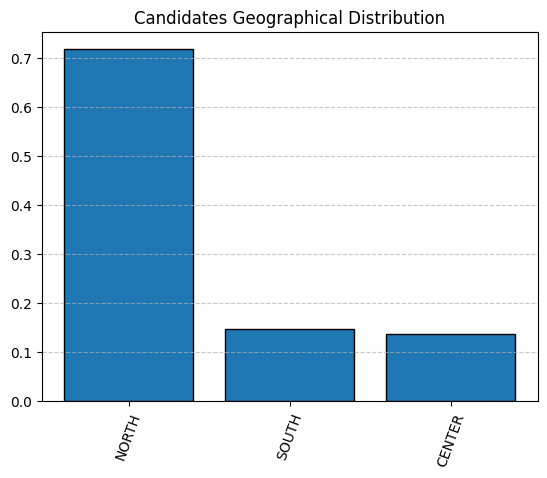

In [44]:
df_skill_candidates_localized = df_skill_candidates.with_columns(
    pl.when(pl.col("LATITUDE") > 44.5)
    .then(pl.lit("NORTH"))
    .when(pl.col("LATITUDE") < 42)
    .then(pl.lit("SOUTH"))
    .otherwise(pl.lit("CENTER"))
    .alias("Location")
)
df_location_per_candidate = df_skill_candidates_localized.select(
    "CANDIDATE_ID", "Location"
).unique()
plot_histogram(
    df_location_per_candidate["Location"],
    title="Candidates Geographical Distribution",
    normalize=True,
)

The charts below display the **percentage distribution** of each `Skill_Type` within three geographic regions (North, Center, South). Each histogram is normalized, so differences in absolute CV counts (e.g., 71% of candidates coming from the North) do not affect the shape of the distribution **across** regions. The y-axis values represent the relative share of each skill type among CVs from that specific area, regardless of the total volume of CVs.

> Note: The only noticeable difference is that in the **South**, the `Job_title` category is slightly more prevalent than `IT_Skill`. In the North and Center, these two categories remain roughly similar. All other proportions (e.g., the dominance of `Professional_Skill` and the marginal share of `DRIVERSLIC`) are nearly identical across regions.  

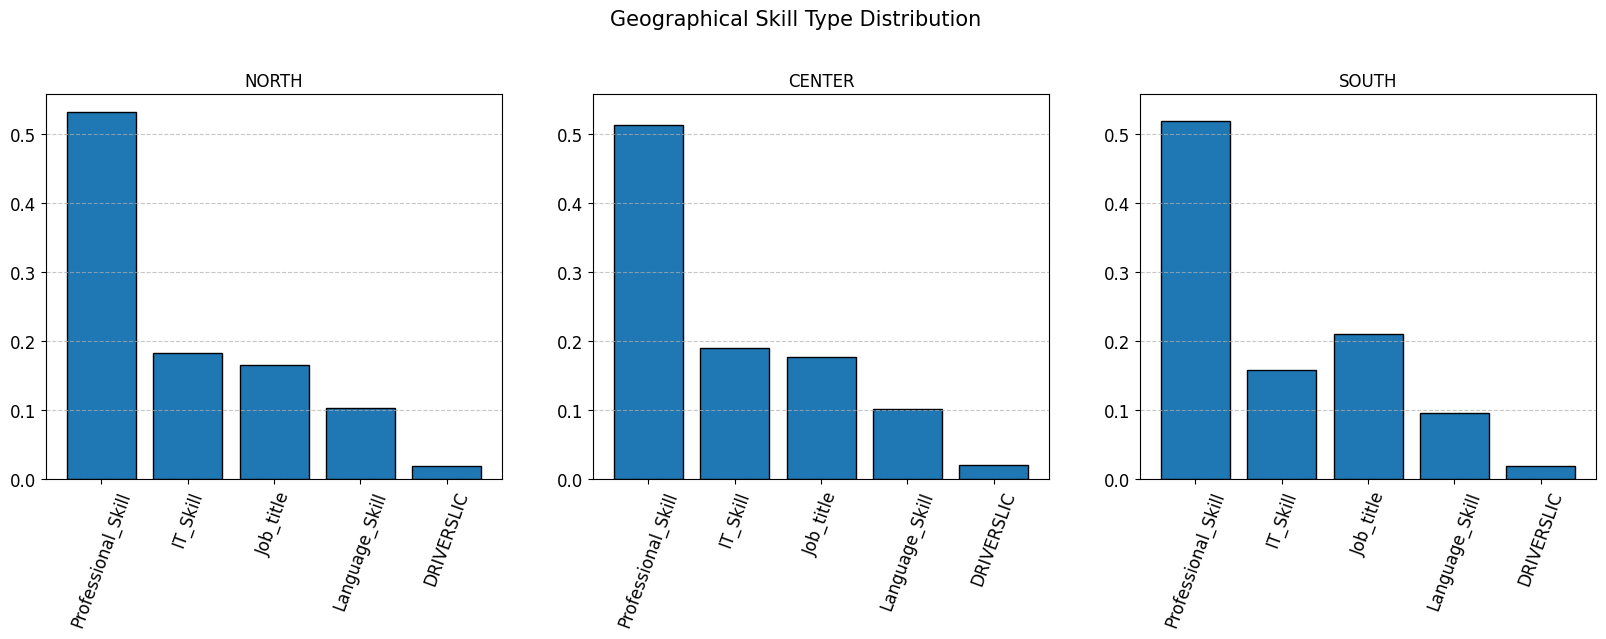

In [45]:
skills_per_location = split_df_per_attribute(df_skill_candidates_localized, "Location")
plot_target_distribution(skills_per_location, "Geographical Skill Type Distribution")

When comparing how specific skills are distributed across multiple geographic regions, it is crucial to identify which skills exhibit the most pronounced imbalance. 
The technique employed here involves:

1. **Cutting out low frequencies skills**: first applying *log trasformation* on the total counts distribution, then computing *z-score* for each count and lastly filtering out those that are below a certain threshold.  

2. **Gathering frequency counts (already scaled considering the groups prior distribution)** of each skill within each group.  (considering only skills as described in 1.) 

3. **Quantifying inequality** for each skill across these groups using a statistical measure.  

4. **Selecting the top skills with the maximum inequality** and visualizing its breakdown to facilitate interpretation.

**The Gini Index as an Inequality Metric**

The chosen disparity metric is the **Gini index**, a widely used measure of statistical dispersion. For a given skill, let $n$ be the number of groups and let $x_i$ denote the frequency of that skill in group $i$. We denote them by $x_{(1)}$, $x_{(2)}$, $...$, $x_{(n)}$. (in our case $n=3$) The Gini index \(G\) is then computed as:

$$
G \;=\; \frac{\displaystyle\sum_{1 \,\le i < j \,\le n} \bigl|x_i - x_j\bigr|}{\,n \,\sum_{i=1}^{n} x_i\,}\,.
$$

**How this works:**  
1. **Intuition**:  
   - It measures the **average absolute difference** between every pair of group values, scaled by the total.  
   - If all $x_i$ are identical, each $\lvert x_i - x_j\rvert = 0$, so $G=0$ (perfect equality).  
   - If one group has **all** of the mass and the others have zero, then the numerator is maximized, driving $G$ toward 1 (maximal inequality).  

2. **Normalization**:  
   - Dividing by $n \sum_{i=1}^{n} x_i$ ensures $G$ ranges between 0 and (just under) 1 regardless of absolute scale or number of groups.  
   - In practice, $G$ approaches 1 when one group’s share dominates and the rest contribute negligibly.

3. **Interpretation**:  
   - A **low Gini** (near 0) indicates the attribute is nearly equally represented across all groups.  
   - A **high Gini** signals that the attribute is concentrated in one or a few groups, revealing a strong disparity.



> **Note:** The Gini index’s maximum value is $(n-1)/n$. For $n=3$, this gives a range from 0 up to $2/3$ (approximately 0.667).

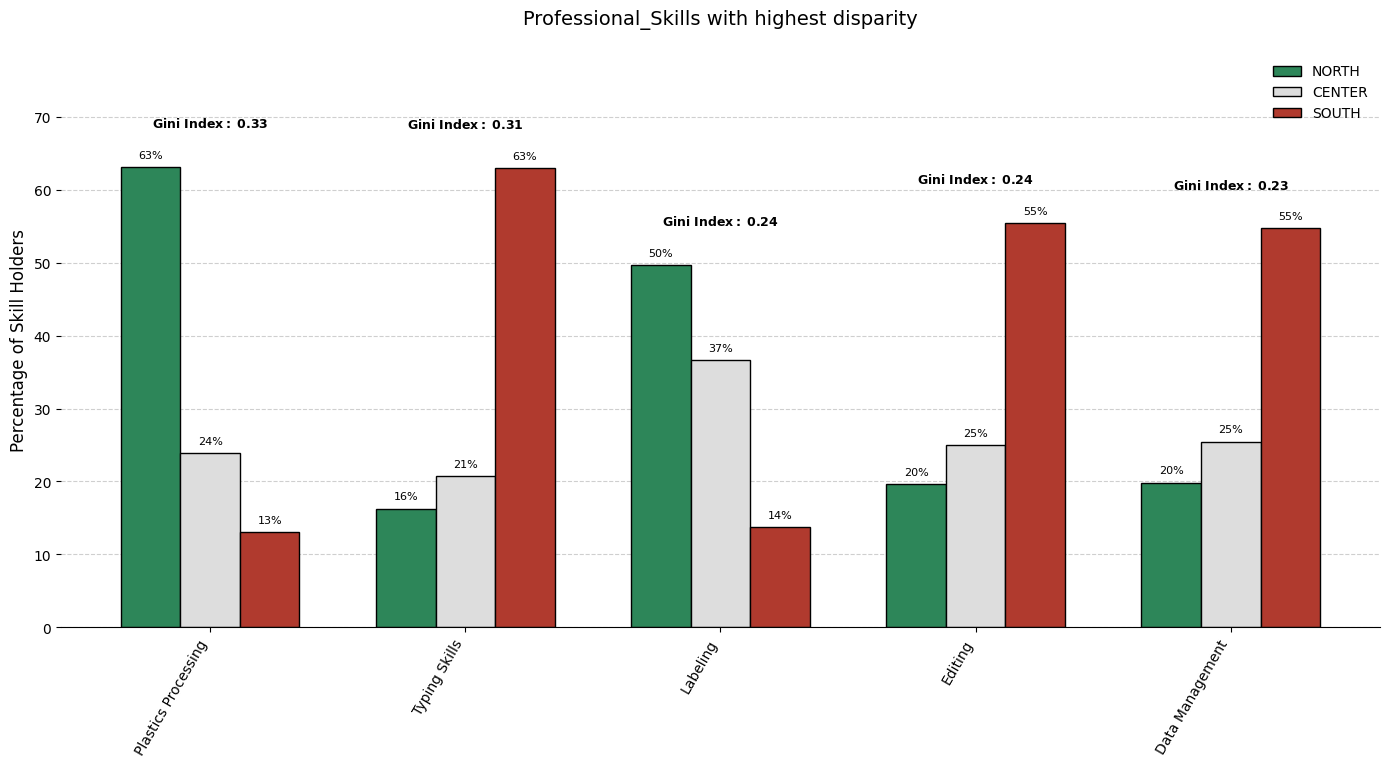

In [46]:
prof_skills_per_location = {
    attr: df.filter(pl.col("Skill_Type") == "Professional_Skill")["Skill"]
    for attr, df in skills_per_location.items()
}


location_colors = {"NORTH": "#2d8659", "CENTER": "#dddddd", "SOUTH": "#b03a2e"}

location_weights = {
    key: 1 / len(df["CANDIDATE_ID"].unique()) for key, df in skills_per_location.items()
}

compute_and_plot_disparity(
    prof_skills_per_location,
    min_threshold=1.0,
    colors=location_colors,
    attribute_name="Professional_Skills",
    weights_dict=location_weights,
)

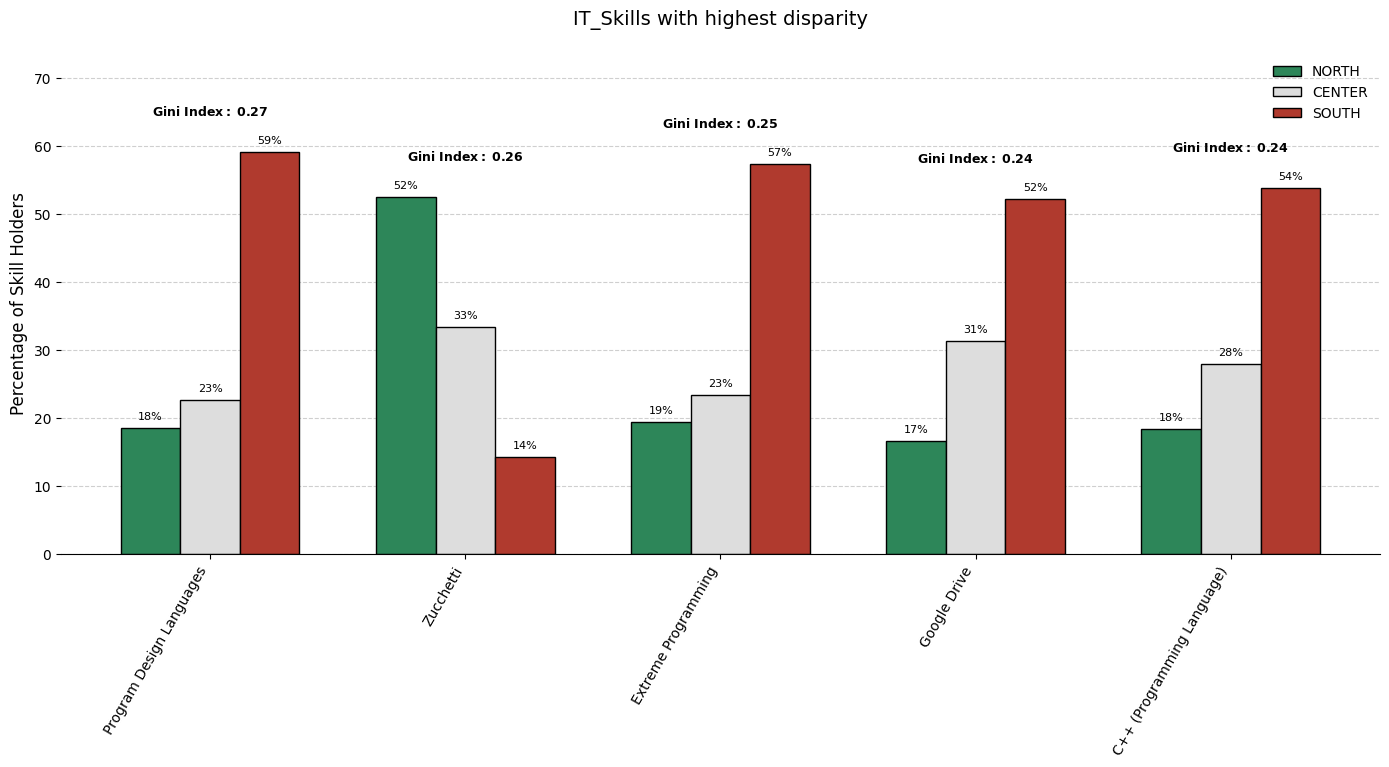

In [47]:
it_skills_per_location = {
    attr: df.filter(pl.col("Skill_Type") == "IT_Skill")["Skill"]
    for attr, df in skills_per_location.items()
}


compute_and_plot_disparity(
    it_skills_per_location,
    colors=location_colors,
    attribute_name="IT_Skills",
    weights_dict=location_weights,
)

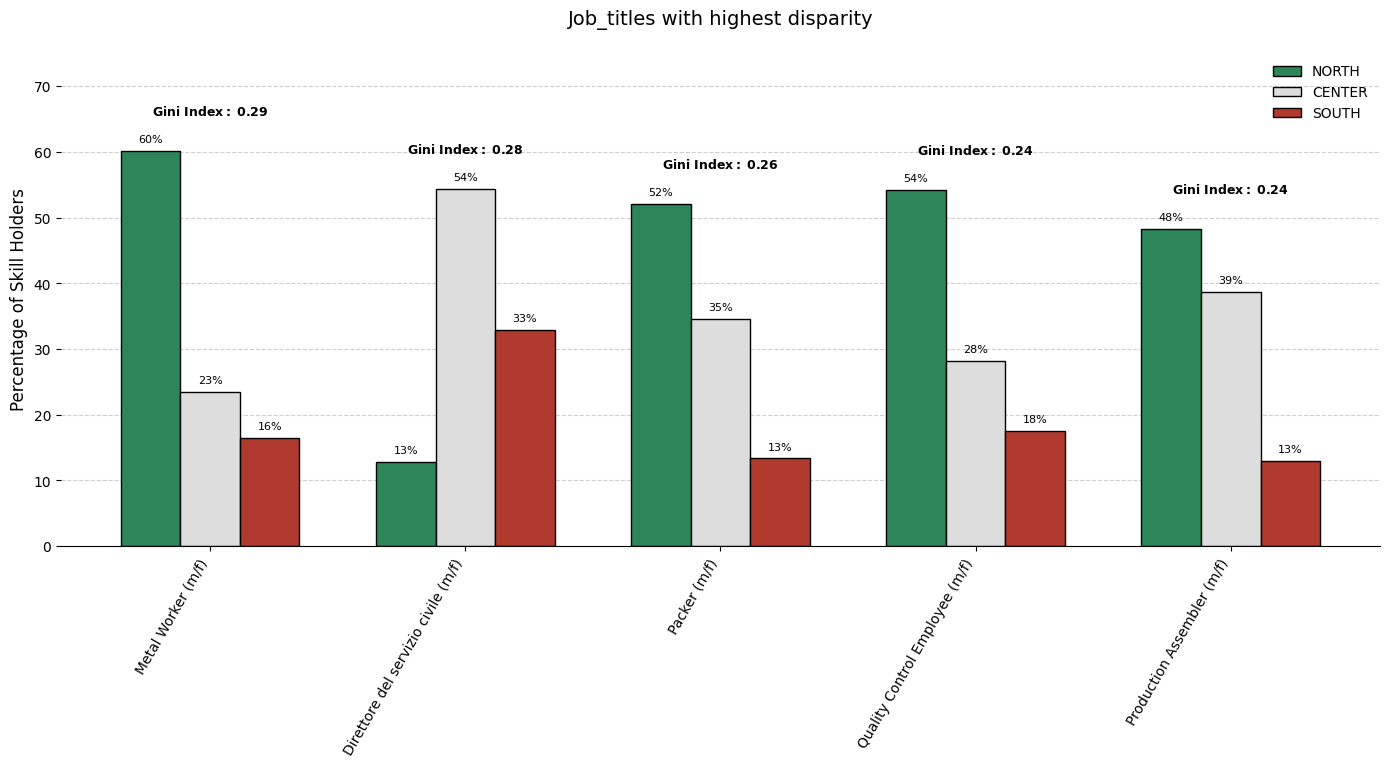

In [48]:
job_title_per_location = {
    attr: df.filter(pl.col("Skill_Type") == "Job_title")["Skill"]
    for attr, df in skills_per_location.items()
}


compute_and_plot_disparity(
    job_title_per_location,
    colors=location_colors,
    attribute_name="Job_titles",
    weights_dict=location_weights,
)

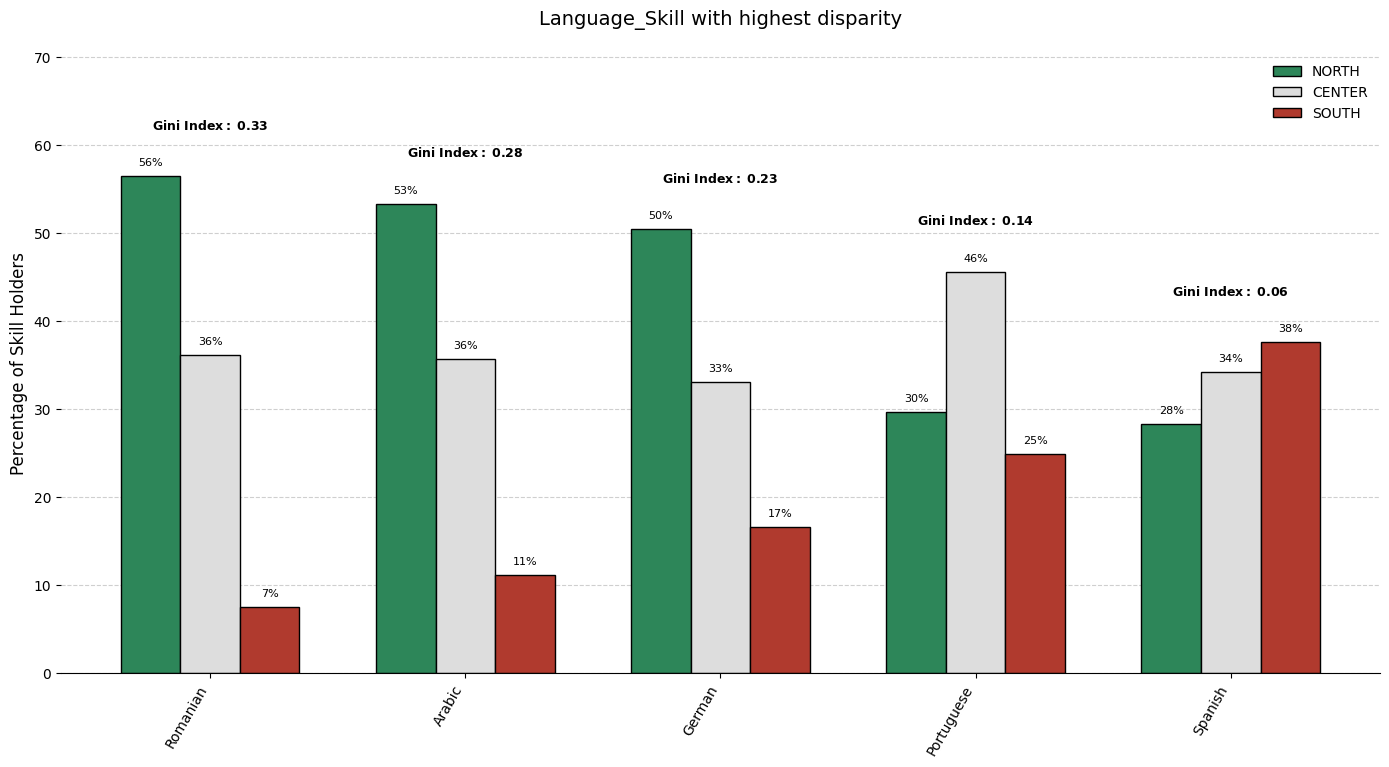

In [49]:
lang_skills_per_location = {
    attr: df.filter(pl.col("Skill_Type") == "Language_Skill")["Skill"]
    for attr, df in skills_per_location.items()
}


compute_and_plot_disparity(
    lang_skills_per_location,
    min_threshold=0.0,
    colors=location_colors,
    attribute_name="Language_Skill",
    weights_dict=location_weights,
)

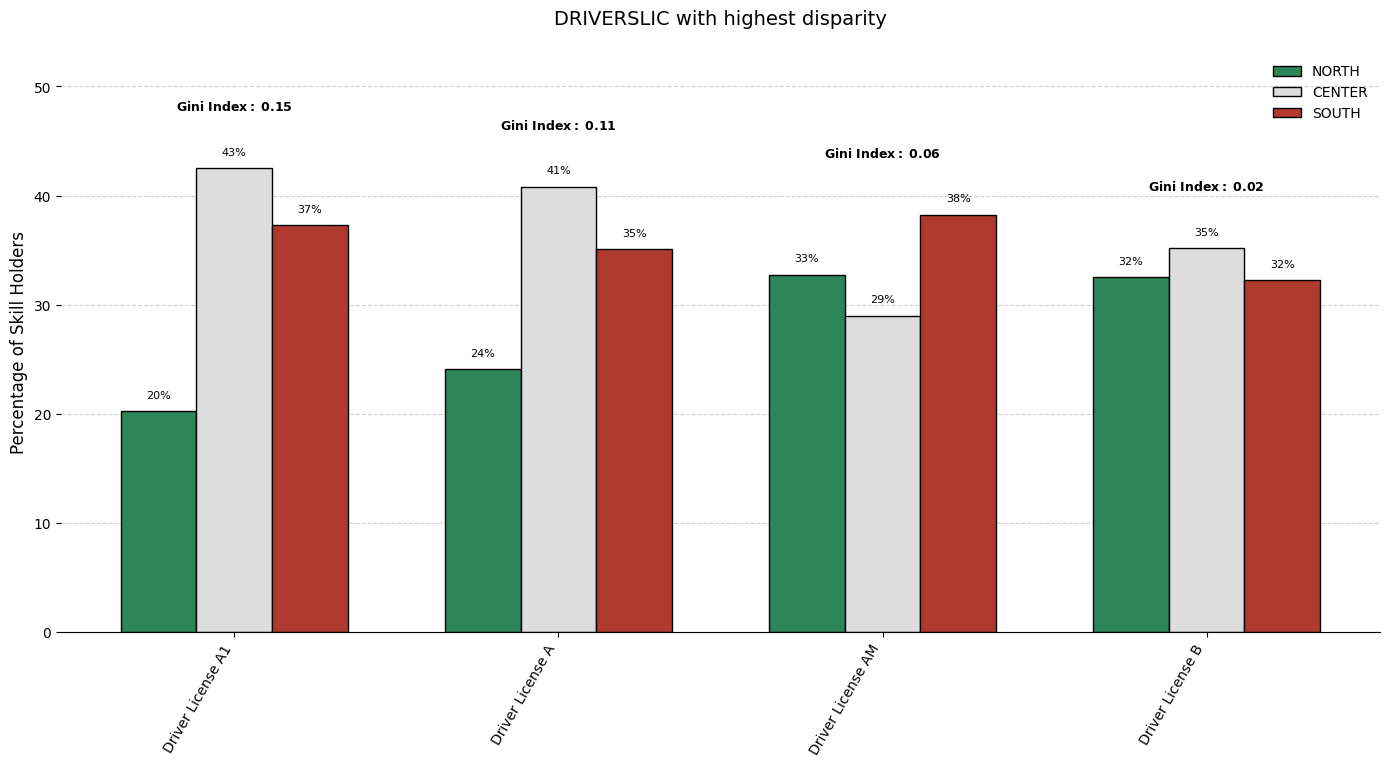

In [50]:
driverslic_per_location = {
    attr: df.filter(pl.col("Skill_Type") == "DRIVERSLIC")["Skill"]
    for attr, df in skills_per_location.items()
}


compute_and_plot_disparity(
    driverslic_per_location,
    min_threshold=0.0,
    colors=location_colors,
    attribute_name="DRIVERSLIC",
    weights_dict=location_weights,
)

## Hard-Soft Skills Analysis

In this section, we analyze the distribution of extracted skills across candidates by incorporating **the hard/soft skills label**. 

We will see the relations between this label and the two areas already explored, with the aim to investigate better possible biases. 

In [51]:
hard_soft_skills = load_data(HARD_SOFT_SKILLS)
df_skills_with_label = df_skills.join(hard_soft_skills, on="Skill")
df_skills_with_gender = df_skills_with_label.join(
    df_info_candidates.select(["CANDIDATE_ID", "Gender"]), on="CANDIDATE_ID"
)
df_skills_with_gender

CANDIDATE_ID,Skill,Skill_Type,label,Gender
i64,str,str,str,str
7974050,"""Billing Processes""","""Professional_Skill""","""Hard""","""Female"""
7974050,"""Databases""","""Professional_Skill""","""Hard""","""Female"""
7974050,"""Polling""","""Professional_Skill""","""Hard""","""Female"""
7965670,"""Accounting""","""Professional_Skill""","""Hard""","""Female"""
7965670,"""Administrative Operations""","""Professional_Skill""","""Soft""","""Female"""
…,…,…,…,…
18233,"""Knowledge of Finance""","""Professional_Skill""","""Hard""","""Female"""
18233,"""Maintenance""","""Professional_Skill""","""Hard""","""Female"""
18233,"""Multi-Level Marketing""","""Professional_Skill""","""Unknown""","""Female"""


Let's now see the gender distribution on this section of candidates. 

In [52]:
gender_counts_df = get_category_distribution(df_info_candidates, "Gender")
gender_counts_df

Gender,count,percentage
str,u32,f64
"""Male""",3984,53.0
"""Female""",3420,45.5
"""Other""",106,1.4
"""Unknown""",11,0.1


In [53]:
df_gender_bias = get_skill_target_share(
    df_skills_with_gender,
    gender_counts_df,
    target_col="Gender",
    target_values=["Male", "Female"],
    skill_col=["label"],
)
df_gender_bias

label,count_male,count_female,count_total,perc_male,perc_female,count_diff,perc_diff
str,i64,i64,i64,f64,f64,i64,f64
"""Hard""",24441,23143,47584,51.4,48.6,1298,2.8
"""Soft""",6435,9787,16222,39.7,60.3,-3352,-20.6
"""Unknown""",1441,1283,2724,52.9,47.1,158,5.8


As we can see from the chart below, soft skills are prevalent for female candidates. (counts are normalized, as before, considering the prior distribution)

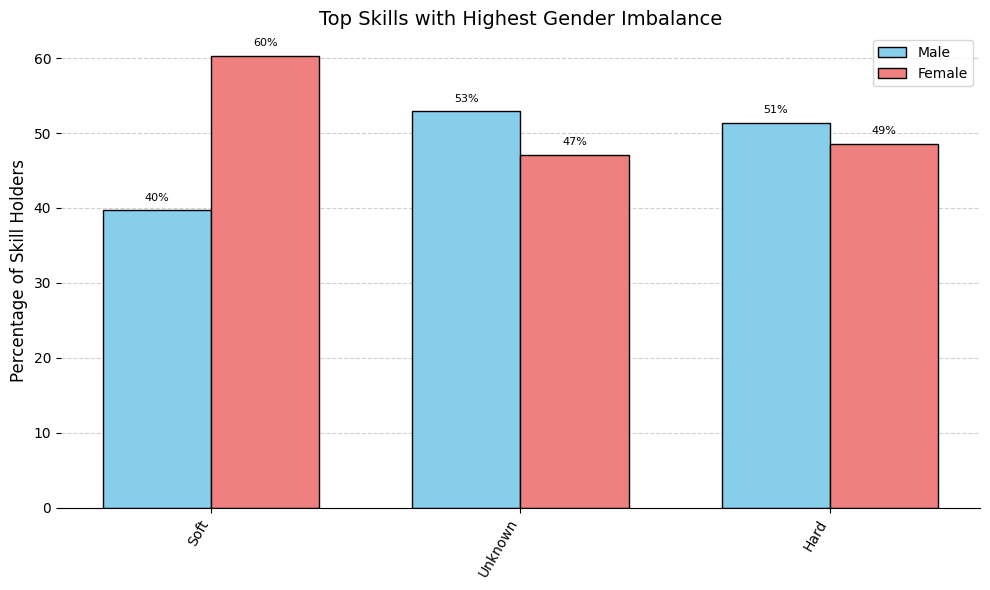

In [54]:
plot_bias_skills_bar(
    df_gender_bias,
    "label",
    gender_percs_dict,
    "perc_diff",
    "Top Skills with Highest Gender Imbalance",
    colors=gender_colors,
    figsize=(10, 6),
)

### Hard/Soft Skills: Geographical Analysis

In [55]:
df_skills_with_location = df_skills_with_label.join(
    df_skill_candidates_localized.select("CANDIDATE_ID", "Location", "Skill"),
    on=["CANDIDATE_ID", "Skill"],
    coalesce=True,
)
df_skills_with_location

CANDIDATE_ID,Skill,Skill_Type,label,Location
i64,str,str,str,str
7974050,"""Billing Processes""","""Professional_Skill""","""Hard""","""CENTER"""
7974050,"""Databases""","""Professional_Skill""","""Hard""","""CENTER"""
7974050,"""Polling""","""Professional_Skill""","""Hard""","""CENTER"""
7965670,"""Accounting""","""Professional_Skill""","""Hard""","""NORTH"""
7965670,"""Administrative Operations""","""Professional_Skill""","""Soft""","""NORTH"""
…,…,…,…,…
18233,"""Knowledge of Finance""","""Professional_Skill""","""Hard""","""NORTH"""
18233,"""Maintenance""","""Professional_Skill""","""Hard""","""NORTH"""
18233,"""Multi-Level Marketing""","""Professional_Skill""","""Unknown""","""NORTH"""


In [56]:
location_counts_df = get_category_distribution(
    df_skill_candidates_localized.unique("CANDIDATE_ID"), "Location"
)
location_counts_df

Location,count,percentage
str,u32,f64
"""NORTH""",5397,71.8
"""SOUTH""",1098,14.6
"""CENTER""",1026,13.6


In [57]:
df_location_bias = get_skill_target_share(
    df_skills_with_location,
    location_counts_df,
    target_col="Location",
    target_values=["NORTH", "CENTER", "SOUTH"],
    skill_col=["label"],
)
df_location_bias

label,count_north,count_center,count_south,count_total,perc_north,perc_center,perc_south,count_diff,perc_diff
str,i64,i64,i64,i64,f64,f64,f64,i64,f64
"""Hard""",21928,12850,13754,48532,45.2,26.5,28.3,5449,11.3
"""Soft""",7158,4269,5150,16577,43.2,25.8,31.1,1338,8.1
"""Unknown""",1280,723,761,2764,46.3,26.2,27.5,346,12.5


As shown in the chart below, the Northern bars are consistently the tallest, indicating that candidates from the **North** have, on average, **more skills**.

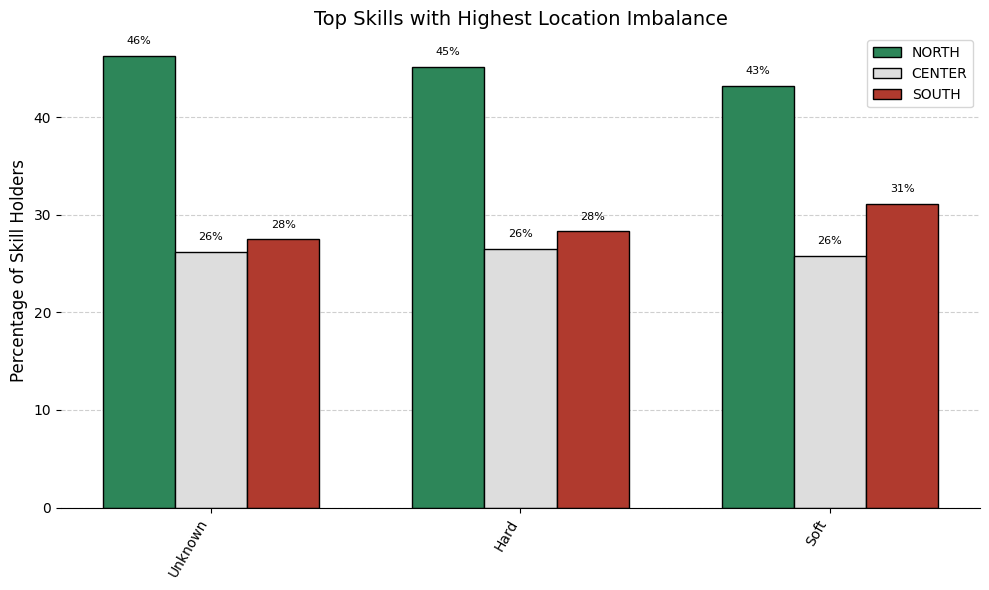

In [58]:
location_percs_dict = {
    "NORTH": "perc_north",
    "CENTER": "perc_center",
    "SOUTH": "perc_south",
}

plot_bias_skills_bar(
    df_location_bias,
    "label",
    location_percs_dict,
    "perc_diff",
    "Top Skills with Highest Location Imbalance",
    colors=location_colors,
    figsize=(10, 6),
)